In [6]:
import numpy as np
from tqdm import tqdm
from scipy.special import logsumexp
import pandas as pd
class MLP():
    
    def __init__(self, din, dout):
        self.W = (2 * np.random.rand(dout, din) - 1) * (np.sqrt(6) / np.sqrt(din + dout))
        self.b = (2 * np.random.rand(dout) - 1) * (np.sqrt(6) / np.sqrt(din + dout))
        
    def forward(self, x): # x.shape = (batch_size, din)
        self.x = x # Storing x for latter (backward pass)
        return x @ self.W.T + self.b

    def backward(self, gradout):
        self.deltaW = gradout.T @ self.x
        self.deltab = gradout.sum(0)
        return gradout @ self.W
    
class SequentialNN():
    
    def __init__(self, blocks: list):
        self.blocks = blocks
        
    def forward(self, x):
        
        for block in self.blocks:
            x = block.forward(x)
  
        return x

    def backward(self, gradout):
        
        for block in self.blocks[::-1]:
            gradout = block.backward(gradout)
            
        return gradout

class ReLU():
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, gradout):
        new_grad = gradout.copy()
        new_grad[self.x < 0] = 0.
        return new_grad
    
class LogSoftmax():
    
    def forward(self, x):
        self.x = x
        return x - logsumexp(x, axis=1)[..., None]
    
    def backward(self, gradout):
        gradients = np.eye(self.x.shape[1])[None, ...]
        gradients = gradients - (np.exp(self.x) / np.sum(np.exp(self.x), axis=1)[..., None])[..., None]
        return (np.matmul(gradients, gradout[..., None]))[:, :, 0]
    
class NLLLoss():
    
    def forward(self, pred, true):
        self.pred = pred
        self.true = true
        
        loss = 0
        for b in range(pred.shape[0]):
            loss -= pred[b, true[b]]
        return loss

    def backward(self):
        din = self.pred.shape[1]
        jacobian = np.zeros((self.pred.shape[0], din))
        for b in range(self.pred.shape[0]):
            jacobian[b, self.true[b]] = -1

        return jacobian # batch_size x din
    
    def __call__(self, pred, true):
        return self.forward(pred, true)
    
class Optimizer():
    
    def __init__(self, lr, compound_nn: SequentialNN):
        self.lr = lr
        self.compound_nn = compound_nn
        
    def step(self):
        
        for block in self.compound_nn.blocks:
            if block.__class__ == MLP:
                block.W = block.W - self.lr * block.deltaW
                block.b = block.b - self.lr * block.deltab
                
def train(model, optimizer, trainX, trainy, loss_fct = NLLLoss(), nb_epochs=14000, batch_size=100):
    training_loss = []
    for epoch in tqdm(range(nb_epochs)):

        # Sample batch size
        batch_idx = [np.random.randint(0, trainX.shape[0]) for _ in range(batch_size)]
        x = trainX[batch_idx]
        target = trainy[batch_idx]

        prediction = model.forward(x) # Forward pass
        loss_value = loss_fct(prediction, target) # Compute the loss
        training_loss.append(loss_value) # Log loss
        gradout = loss_fct.backward()
        model.backward(gradout) # Backward pass

        # Update the weights
        optimizer.step()
    return training_loss

def onehot_encoder(ary, columns=[], remove_trap=False):
    df_results = pd.DataFrame()

    # Iterate each column in DataFrame ary
    for i in range(ary.shape[1]):
        # if this column (i) is dummy column
        if i in columns:
            base_name = ary.columns[i]
            this_column = pd.get_dummies(ary.iloc[:, i])
            this_column = this_column.rename(columns={n:"{}_{}".format(base_name, n) for n in this_column.columns})
            # Remove Dummy Variable Trap if needed
            if remove_trap:
                this_column = this_column.drop(this_column.columns[0], axis=1)
        # else this column is normal column
        else:
            this_column = ary.iloc[:, i]
        # Append this column to the Result DataFrame
        df_results = pd.concat([df_results, this_column], axis=1)

    return df_results

 
if __name__ == "__main__": 
    # Load and process data
    
    train_df = pd.read_csv('./train_preproceed.csv')
    test_df = pd.read_csv('./test.csv')
    train_df = train_df.sample(n=10000, random_state=42)  # 使用 random_state 以确保可重复性

    train_df_ = onehot_encoder(train_df, columns=[1, 2], remove_trap=True)
    #test_df = onehot_encoder(test_df, columns=[1, 2], remove_trap=True)
    

    train_df = train_df_.sample(n=1000, random_state=42)  # 使用 random_state 以确保可重复性
    val_df = train_df_.sample(n=1000, random_state=38)  # 使用 random_state 以确保可重复性

    X_train = train_df_.iloc[:, :-1].values
    Y_train = train_df_.iloc[:, -1].values.reshape(-1,1)
    X_test = val_df.iloc[:, :-1].values
    Y_test = val_df.iloc[:, -1].values.reshape(-1,1)

    print(X_train.shape)
    print(X_test.shape)

    mlp = SequentialNN([MLP(35, 128), ReLU(), 
                        MLP(128, 64), ReLU(), 
                        MLP(64, 2), LogSoftmax()])
    optimizer = Optimizer(1e-3, mlp)

    training_loss = train(mlp, optimizer, X_train, Y_train)

    # Compute test accuracy
    accuracy = 0
    for i in range(X_test.shape[0]):
        prediction = mlp.forward(X_test[i].reshape(1, 35)).argmax()
        if prediction == Y_test[i]: accuracy += 1
    print('Test accuracy', accuracy / X_test.shape[0] * 100, '%')


(10000, 35)
(1000, 35)


100%|██████████| 14000/14000 [01:12<00:00, 191.90it/s]


Test accuracy 64.2 %


In [1]:
import pandas as pd #To read and edit tabular data
import numpy as np #To perform array/matrix operations
import math #For mathematical opeartions
import matplotlib.pyplot as plt #To perform plotting
%matplotlib inline
import seaborn as sns  #To perform visualization
sns.set_style('whitegrid')
import warnings #To ignore warnings
warnings.filterwarnings('ignore')
from IPython.display import Image #To display images in the notebook

In [2]:
#%% Parameter initialize and sigmoid function

def initialize_weights_and_bias(dimension):
    
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w,b

def sigmoid(z):
    
    y_head = 1 / (1+np.exp(-z))
    
    return y_head
#%% Forward and Backward Propagation

def forward_backward_propagation(w,b,x_train,y_head):
    
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head) - (1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss)) / x_train.shape[1]
    
    #backward propogation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1]
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost,gradients

#%% Updating (Learning) Parameters
    
def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    # updating(learning) parameters is number_of_iterarion times
    for i in range(number_of_iterarion):
        # make forward and backward propagation and find cost and gradients
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        # lets update
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 10 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost)) #if section defined to print our cost values in every 10 iteration. We do not need to do that. It's optional.
    # we update(learn) parameters weights and bias
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iteration")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list

#%% Prediction

def predict(w,b,x_test):
    # x_test is a input for forward propagation
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))
    # if z is bigger than 0.5, our prediction is one means has diabete (y_head=1),
    # if z is smaller than 0.5, our prediction is zero means does not have diabete (y_head=0),
    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

#predict(parameters["weight"],parameters["bias"],x_test)

def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):
    # initialize
    dimension =  x_train.shape[0]
    w,b = initialize_weights_and_bias(dimension)
    
    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    

    # Print train/test Errors
    
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))
    
    

Cost after iteration 0: 0.693905
Cost after iteration 10: 0.692548
Cost after iteration 20: 0.692311
Cost after iteration 30: 0.692085
Cost after iteration 40: 0.691861
Cost after iteration 50: 0.691640
Cost after iteration 60: 0.691422
Cost after iteration 70: 0.691206
Cost after iteration 80: 0.690992
Cost after iteration 90: 0.690781


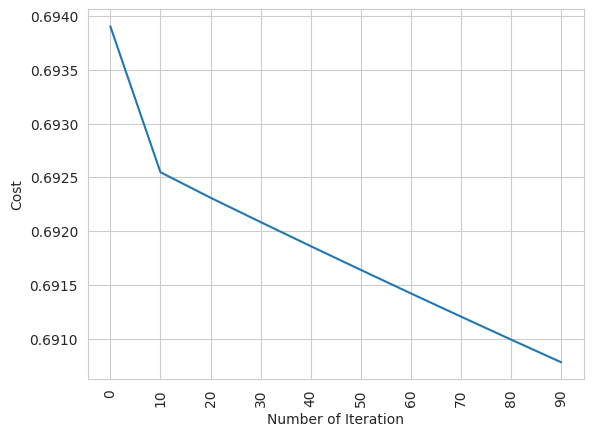

test accuracy: 53.515625 %


In [9]:

train_df = pd.read_csv('./train_preproceed.csv')
test_df = pd.read_csv('./test.csv')

train_df = pd.get_dummies(train_df, drop_first=True)

#test_df = pd.get_dummies(test_df, drop_first=True)

train_df = train_df.sample(n=1280, random_state=42)  # 使用 random_state 以确保可重复性

x_train = train_df.drop('is_claim', axis=1).values
y_train = train_df['is_claim'].values

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,test_size = 0.2, random_state = 42)

x_train = x_train.T
x_test = x_test.T
y_train = y_train.T
y_test = y_test.T

logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 0.01, num_iterations = 100)
